<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/Encoder_Decoder_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Data Preprocessing

In [ ]:
# Transformer adding noise 20%
transform = transforms.Compose([
    transforms.ToTensor()
])

# Downloading Data
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size= 128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 128, shuffle=False)

In [ ]:
classes = train_data.classes
print(classes)


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
print(train_data[2][0].shape)

torch.Size([1, 28, 28])


### Visualising Data without noise and with noise

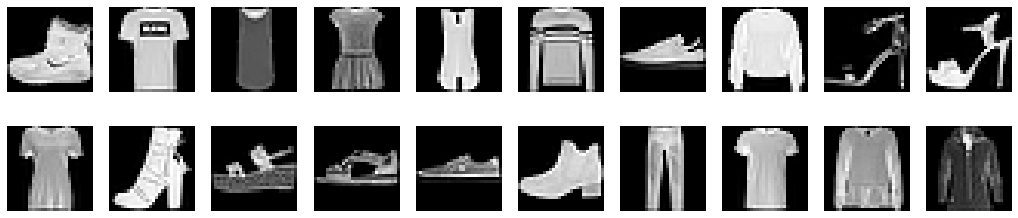

In [ ]:
figure = plt.figure(figsize=(18, 4))
cols, rows = 10, 2

for i in range(cols * rows):
  img, label = train_data[i]
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1

  plt.imshow(img.numpy().transpose(1,2,0),cmap='gray')
 
  
  plt.axis("off")

plt.show()

In [ ]:
def add_noise(inputs):
     noise = torch.randn_like(inputs)*0.2
     return inputs + noise

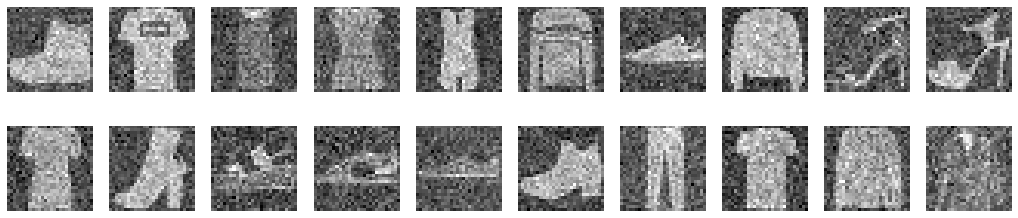

In [ ]:
figure = plt.figure(figsize=(18, 4))
cols, rows = 10, 2

for i in range(cols * rows):
  img, label = train_data[i]
  img = add_noise(img)
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1

  plt.imshow(img.numpy().transpose(1,2,0),cmap='gray')
 
  
  plt.axis("off")

plt.show()

### part a

# Model with 1 FC layer

In [ ]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Sigmoid()
        )


    def forward(self, x):

        x_noise = add_noise(x)

        # Encode the input
        encoded = self.encoder(x_noise)

        # Decode the encoded input
        decoded = self.decoder(encoded)

        # Flatten the encoded output for classification
        flattened = encoded.view(-1, 64*7*7)

        # Classify the flattened output
        classification = self.classifier(flattened)

        return decoded, classification

### Loss functions

In [ ]:
model = Autoencoder().to(device)
# Define the reconstruction loss function
recon_loss_fn = nn.MSELoss()

# Define the classification loss function
classif_loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training the encoder - decoder (classifier not trained)

In [ ]:
loss_list = []
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):

        inputs = inputs.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat, classified = model(inputs)
        # calculate loss

        loss = recon_loss_fn(yhat, inputs)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            loss_list.append(running_loss / 200)
            running_loss = 0.0

print('Finished Training.')

[1,   200] loss: 0.101
[1,   400] loss: 0.021
[2,   200] loss: 0.015
[2,   400] loss: 0.013
[3,   200] loss: 0.011
[3,   400] loss: 0.010
[4,   200] loss: 0.010
[4,   400] loss: 0.009
[5,   200] loss: 0.009
[5,   400] loss: 0.009
[6,   200] loss: 0.008
[6,   400] loss: 0.008
[7,   200] loss: 0.008
[7,   400] loss: 0.008
[8,   200] loss: 0.007
[8,   400] loss: 0.007
[9,   200] loss: 0.007
[9,   400] loss: 0.007
[10,   200] loss: 0.007
[10,   400] loss: 0.007
Finished Training.


### Average loss curve

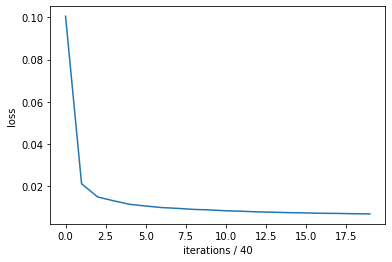

In [ ]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('iterations / 200')
plt.ylabel('loss')
plt.show()

### Training the classifier

In [ ]:
# Set requires_grad to False for encoder and decoder parameters
for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.decoder.parameters():
    param.requires_grad = False

# Set requires_grad to True for classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
loss_list = []
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat, classified = model(inputs)
        # calculate loss
        
        loss = classif_loss_fn(classified, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 40 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            loss_list.append(running_loss / 200)
            running_loss = 0.0

print('Finished Training.')

[1,   200] loss: 1.800
[1,   400] loss: 1.719
[2,   200] loss: 1.701
[2,   400] loss: 1.655
[3,   200] loss: 1.627
[3,   400] loss: 1.623
[4,   200] loss: 1.617
[4,   400] loss: 1.615
[5,   200] loss: 1.609
[5,   400] loss: 1.608
[6,   200] loss: 1.597
[6,   400] loss: 1.596
[7,   200] loss: 1.590
[7,   400] loss: 1.590
[8,   200] loss: 1.589
[8,   400] loss: 1.590
[9,   200] loss: 1.587
[9,   400] loss: 1.592
[10,   200] loss: 1.587
[10,   400] loss: 1.591
Finished Training.


### Average loss curve

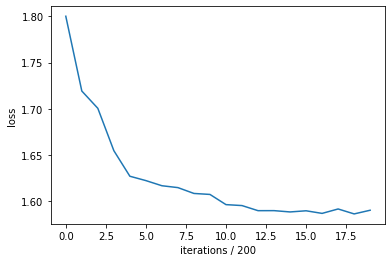

In [ ]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('iterations / 200')
plt.ylabel('loss')
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        yhat, outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Model 1 Accuracy: {100 * correct // total} %')

Model 1 Accuracy: 74 %


## Noisy image and their Reconstruction using Model

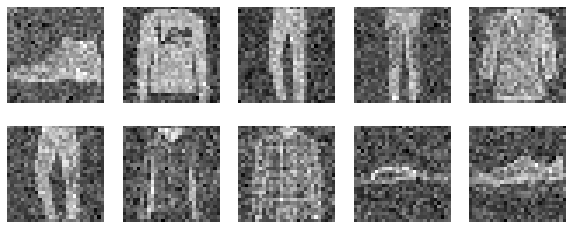

In [ ]:
# test data
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2

for i in range(cols * rows):
  img, label = test_data[i]
  img = add_noise(img)
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1
  plt.imshow(img.numpy().transpose(1,2,0), cmap = 'gray')
 
  
  plt.axis("off")

plt.show()

### Reconstructed image

In [ ]:
img, label = test_data[i]
img = img.to(device)
reconstructed_img, classified = model(img.unsqueeze(0))

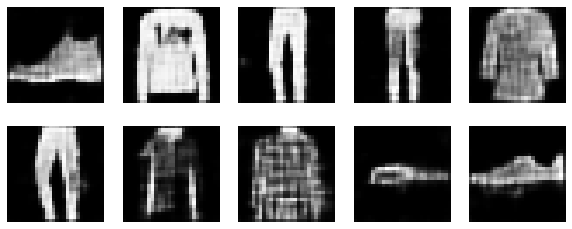

In [ ]:
# test data reconstruction

figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2

for i in range(cols * rows):
  img, label = test_data[i]
  img = img.to(device)
  reconstructed_img, classified = model(img.unsqueeze(0))
  reconstructed_img = reconstructed_img.to('cpu').squeeze(0)

  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1
  plt.imshow(reconstructed_img.detach().numpy().transpose(1,2,0), cmap = 'gray')
  
  plt.axis("off")

plt.show()


# part 4

### t-SNE PLOT

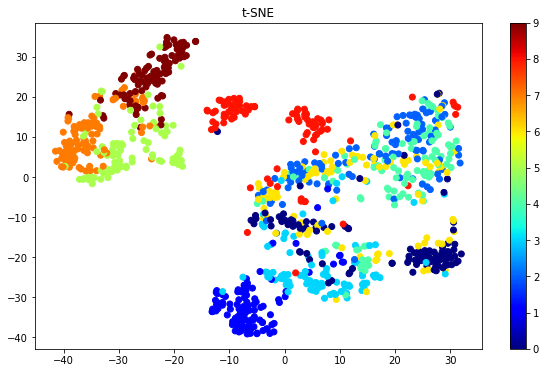

In [ ]:
from sklearn.manifold import TSNE

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# Get the encoded feature vectors for the first 1000 images from the test dataset
feature_encoded_list = []
label_list = []
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    encoded = model.encoder(images)
    encoded = encoded.view(encoded.size(0), -1).to('cpu').detach().numpy()
    feature_encoded_list.append(encoded)
    label_list.append(targets.to('cpu').detach().numpy())
feature_encoded_list = np.vstack(feature_encoded_list)[:1000]
label_list = np.hstack(label_list)[:1000]

# Use t-SNE to reduce the dimensionality of the encoded feature vectors to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
feature_encoded_list_tsne = tsne.fit_transform(feature_encoded_list)

# Plot the encoded feature vectors in a 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(feature_encoded_list_tsne[:, 0], feature_encoded_list_tsne[:, 1], c=label_list, cmap='jet')
plt.colorbar()
plt.title('t-SNE')
plt.show()

REFERENCES


1.   https://www.kaggle.com/code/weka511/autoencoder-implementation-in-pytorch/notebook
2.   https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

